## Plot spike trains
-------

Example notebook demonstrating simple functions in SynapticConn for plotting spike trains. 

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt

os.chdir('../..')
print(os.getcwd())

from synapticonn.plots import plot_acg

/Users/michael.zabolocki/Desktop/code/SynaptiConn


Load data. 

In [37]:
data_fpath = pathlib.Path('tests', 'BD0187_spikesorting_array.pkl')

# open pickle
all_units = pd.read_pickle(data_fpath)
all_units = all_units['spike_time_set']
spike_train_1 = all_units[0]/30_000  # unit 0
spike_train_2 = all_units[1]/30_000  # unit 1

In [38]:
all_units.keys()

dict_keys([np.int32(5), np.int32(1), np.int32(0), np.int32(16), np.int32(17), np.int32(18), np.int32(15), np.int32(4), np.int32(3)])

Plot spike train.

In [39]:
# import matplotlib.pyplot as plt

# n_cells = all_units['unit_t'].shape[1]

# # plot spike trains for each cell
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# for cell in range(n_cells):
#     ax.eventplot(all_units['unit_t'][0][cell].T, lineoffsets=cell, colors='k', linewidths=0.5)
    
# # axis labels
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Cell #')

# plt.show()

Plot autocorrelograms for individual cells.

Text(0, 0.5, '')

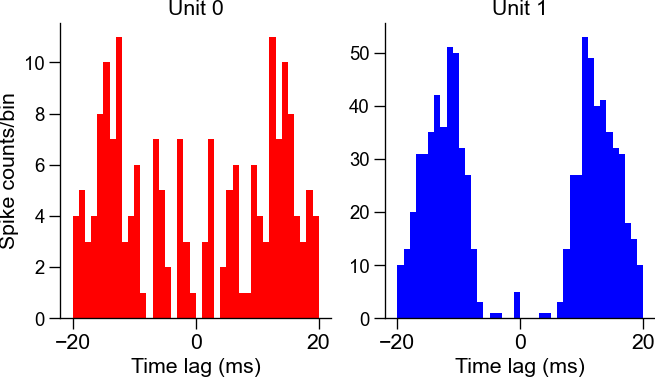

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=False, sharex=True)

# bin parameters
bin_size_ms = 1
max_lag_ms = 20

plot_acg(spike_train_1*1000, bin_size_ms, max_lag_ms, color='red', ax=ax[0], labels=True)
ax[0].set_title('Unit 0')

plot_acg(spike_train_2*1000, bin_size_ms, max_lag_ms, color='blue', ax=ax[1], labels=True)
ax[1].set_title('Unit 1')
ax[1].set_ylabel('')

Cross-correlogram plots between units.

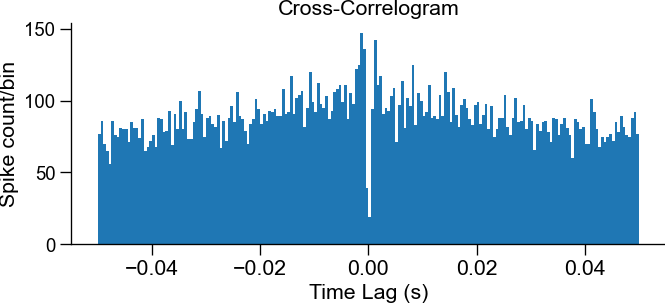

In [20]:

import numpy as np
import matplotlib.pyplot as plt

# Set the bin size and range for the cross-correlogram
bin_size = 0.0005  # 50 ms bins
max_lag = 0.05    # 500 ms maximum lag

# Compute the cross-correlogram
time_diffs = []
for spike1 in spike_train_1:
    for spike2 in spike_train_2:
        diff = spike2 - spike1
        if -max_lag <= diff <= max_lag:
            time_diffs.append(diff)

# Bin the time differences
bins = np.arange(-max_lag, max_lag + bin_size, bin_size)
cross_corr, _ = np.histogram(time_diffs, bins=bins)

# Plot the cross-correlogram
plt.bar(bins[:-1], cross_corr, width=bin_size, align='edge')
plt.title('Cross-Correlogram')
plt.xlabel('Time Lag (s)')
plt.ylabel('Spike count/bin')
plt.show()

TO DO: 
- Plot for multiple spike trains
    - option to subselect for only 1



- Quality controls
    - Build in quality controls to assess the refractory periods (isi violations)
    - Additional QCs?


- Style is not being fitted globally --> the decorator is useless?

- Cross-Correlation Histogram

- Check the distances between the units?

- Document all the steps in place to check this all out ...